# Домашнее задание

In [1]:
import pandas as pd

Для датафрейма log из материалов занятия создайте столбец source_type по правилам:

- если источник traffic_source равен Yandex или Google, то в source_type ставится organic;
- для источников paid и email из России ставим ad;
- для источников paid и email не из России ставим other;
- все остальные варианты берём из traffic_source без изменений.

In [13]:
log_df = pd.read_csv('./data/pt3/visit_log.csv', sep=';')
log_df['traffic_source'] = log_df['traffic_source'].astype(str)
log_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18938 entries, 0 to 18937
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       18938 non-null  int64 
 1   visit_id        18938 non-null  object
 2   url             18938 non-null  object
 3   region          18938 non-null  object
 4   user_id         18938 non-null  object
 5   traffic_source  18938 non-null  object
dtypes: int64(1), object(5)
memory usage: 887.8+ KB


Определим функцию для составления значений требуемого столбца:

In [34]:
def col_prep(row: str):
    is_rus = row['region'] == 'Russia'
    match [ row['traffic_source'], is_rus ]:
        case ['yandex', _] | ['google', _]: return 'organic'
        case ['paid', True] : return 'ad'
        case ['paid', False] : return 'other'
        case _: return row['traffic_source']

Применим преобразование ...

In [26]:
log_df['source_type'] = log_df[['traffic_source', 'region']].apply(col_prep, axis=1)
log_df.head()


,timestamp,visit_id,url,region,user_id,traffic_source,source_type
0,1549980692,e3b0c44298,https://host.ru/3c19b4ef7371864fa3,Russia,b1613cc09f,yandex,organic
1,1549980704,6e340b9cff,https://host.ru/c8d9213a31839f9a3a,Russia,4c3ec14bee,direct,direct
2,1549980715,96a296d224,https://host.ru/b8b58337d272ee7b15,Russia,a8c40697fb,yandex,organic
3,1549980725,709e80c884,https://host.ru/b8b58337d272ee7b15,Russia,521ac1d6a0,yandex,organic
4,1549980736,df3f619804,https://host.ru/b8b58337d272ee7b15,Russia,d7323c571c,yandex,organic


<Axes: xlabel='source_type'>

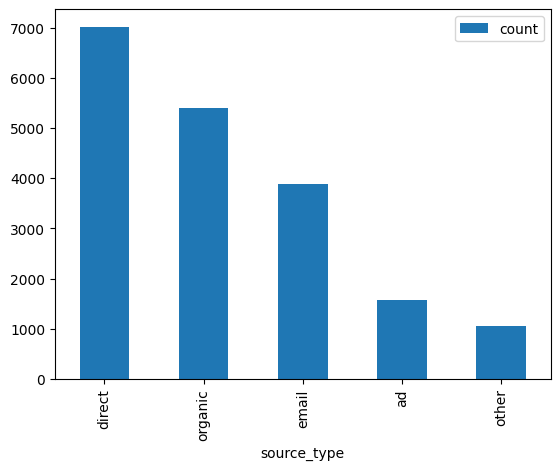

In [33]:
log_df.groupby('source_type').agg(count=('source_type', 'count')).sort_values(by = 'count', ascending=False).plot(kind='bar')

# Задание № 2

В файле URLs.txt содержатся URL страниц новостного сайта. Вам нужно отфильтровать его по адресам страниц с текстами новостей. Известно, что шаблон страницы новостей имеет внутри URL конструкцию: /, затем 8 цифр, затем дефис. Выполните действия:

Прочитайте содержимое файла с датафрейм.
Отфильтруйте страницы с текстом новостей, используя метод str.contains и регулярное выражение в соответствие с заданным шаблоном.

In [62]:
import re

urls = pd.read_csv('./data/pt3/URLs.txt')

def tryFindFirstPattern(p, x):
    founded =  re.findall(p, x)
    if not founded:
        return None
    return founded[0]

urls['m'] = urls['url'].apply(lambda x: tryFindFirstPattern(r"\/(\d{8})\-", x) )
urls[ urls['m'].notna() ].sort_values('m', ascending=False)

,url,m
57,/starlife/36240935-dzhigurde-postavili-diagnoz/,36240935
80,/sport/36235520-v-britanii-razgorelsya-krupney...,36235520
50,/science/36233829-sozdano-lekarstvo-ot-vseh-vi...,36233829
58,/politics/36233197-times-britaniya-peregnula-p...,36233197
19,/cis/36229699-poroshenko-obyavil-vseukrainskiy...,36229699
...,...,...
78,/incidents/36003455-natalya-melamed-pered-gibe...,36003455
6,/video/36001498-poyavilis-pervye-podrobnosti-g...,36001498
88,/cis/35984145-kreml-prokommentiroval-soobschen...,35984145
36,/video/35930625-dozvonivshiysya-v-efir-ukrains...,35930625


# Задание 3

Используйте файл с оценками фильмов ml-latest-small/ratings.csv. 
Посчитайте среднее время жизни пользователей, которые выставили более 100 оценок. 
Под временем жизни понимается разница между максимальным и минимальным значениями столбца timestamp для данного значения userId.

In [95]:
(
    pd.read_csv('./data/pt3/ml-latest-small/ratings.csv')      # читаем файл
    .groupby('userId')                                      # группируем по юзерам
    .agg(                                                   # считаем мин макс и сколько оценил фильмов
        min_ts = ('timestamp', 'min'), 
        max_ts = ('timestamp', 'max'), 
        rated_movies_count = ('rating', 'count'))
    .query("rated_movies_count > 100")                      # только те кто больше 100
    .apply(lambda x: x['max_ts']-x['min_ts'], axis=1)       # размах по времени жизни
    .mean()                                                 # считаем среднее
) 

40080507.4496124

# Задание 4

Дана статистика услуг перевозок клиентов компании по типам (см. файл “Python_13_join.ipynb” в разделе «Материалы для лекции “Продвинутый pandas”» ---- Ноутбуки к лекции «Продвинутый pandas»).
Нужно сформировать две таблицы:

таблицу с тремя типами выручки для каждого client_id без указания адреса клиента;
аналогичную таблицу по типам выручки с указанием адреса клиента.
Обратите внимание, что в процессе объединения таблиц данные не должны теряться.

In [97]:
rzd = pd.DataFrame(
    {
        'client_id': [111, 112, 113, 114, 115],
        'rzd_revenue': [1093, 2810, 10283, 5774, 981]
    }
)

auto = pd.DataFrame(
    {
        'client_id': [113, 114, 115, 116, 117],
        'auto_revenue': [57483, 83, 912, 4834, 98]
    }
)

air = pd.DataFrame(
    {
        'client_id': [115, 116, 117, 118],
        'air_revenue': [81, 4, 13, 173]
    }
)

client_base = pd.DataFrame(
    {
        'client_id': [111, 112, 113, 114, 115, 116, 117, 118],
        'address': ['Комсомольская 4', 'Энтузиастов 8а', 'Левобережная 1а', 'Мира 14', 'ЗЖБИиДК 1',
                    'Строителей 18', 'Панфиловская 33', 'Мастеркова 4']
    }
)

In [111]:
# Вариант 1, простой :)

import duckdb

duckdb.sql("""
    select 
            cb.client_id
        ,   r.rzd_revenue 
        ,   o.auto_revenue 
        ,   a.air_revenue 
    from client_base cb
    left join rzd r on r.client_id = cb.client_id
    left join air a on a.client_id = cb.client_id
    left join auto o on o.client_id = cb.client_id
""").to_df().set_index('client_id').sort_index()

,rzd_revenue,auto_revenue,air_revenue
client_id,,,
111,1093.0,NaN,NaN
112,2810.0,NaN,NaN
113,10283.0,57483.0,NaN
114,5774.0,83.0,NaN
115,981.0,912.0,81.0
116,NaN,4834.0,4.0
117,NaN,98.0,13.0
118,NaN,NaN,173.0


In [109]:
# Вариант 2, сложный :)

d = pd.DataFrame()
d = pd.merge(client_base[['client_id']], rzd, how='left', on='client_id')
d = pd.merge(d, auto, how='left', on='client_id')
d = pd.merge(d, air, how='left', on='client_id')
d.set_index('client_id').sort_index()


,rzd_revenue,auto_revenue,air_revenue
client_id,,,
111,1093.0,NaN,NaN
112,2810.0,NaN,NaN
113,10283.0,57483.0,NaN
114,5774.0,83.0,NaN
115,981.0,912.0,81.0
116,NaN,4834.0,4.0
117,NaN,98.0,13.0
118,NaN,NaN,173.0
